# **Phase 2: Fine Tunning Bart Model on M3**

In [ ]:
import os, json, glob, shutil, re, random
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
from datasets import Dataset
from transformers import AutoTokenizer

# **Preprocessing:**

#### Mount Drive + Load cleaned M3 dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load cleaned M3 JSONL from Drive
import json
from datasets import Dataset

m3_path = "/content/drive/MyDrive/capstone/m3_all_pairs.jsonl"

def load_jsonl(path):
    """Load JSONL file into list of dicts."""
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            rows.append(json.loads(line))
    return rows

# Read cleaned dataset
m3_data = load_jsonl(m3_path)
print("Loaded rows:", len(m3_data))
print("Sample keys:", m3_data[0].keys())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded rows: 1147
Sample keys: dict_keys(['input_text', 'target_text', 'granularity'])


#### Build HF Dataset + Encode Labels + Train/Val Split

In [ ]:
# Convert list of records to Dataset
full_ds = Dataset.from_list(m3_data)
print("Columns:", full_ds.column_names)

# Convert granularity (DOC/SENT/CLAIM) to integer labels
full_ds = full_ds.class_encode_column("granularity")
label_names = full_ds.features["granularity"].names
print("Label names:", label_names)

# Stratified train/validation split
train_test = full_ds.train_test_split(
    test_size=0.15,
    seed=42,
    stratify_by_column="granularity"
)

train_ds = train_test["train"]
val_ds   = train_test["test"]

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))


Columns: ['input_text', 'target_text', 'granularity']


Casting to class labels:   0%|          | 0/1147 [00:00<?, ? examples/s]

Label names: ['CLAIM', 'DOC', 'SENT']
Train samples: 974
Val samples: 173


#### Load tokenizer + Add special tokens

In [ ]:
from transformers import AutoTokenizer

# Base tokenizer for BART
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base", use_fast=True)

# Add custom task + granularity tokens
special_tokens = {
    "additional_special_tokens": [
        "<LEVEL:DOC>", "<LEVEL:SENT>", "<LEVEL:CLAIM>", "<TASK:M3>"
    ]
}
tokenizer.add_special_tokens(special_tokens)

print("Tokenizer vocab size:", len(tokenizer))


Tokenizer vocab size: 50269


#### Preprocessing function (variable length by granularity)

In [ ]:
# Max lengths for different levels
max_src_len_doc   = 1024    # long DOC inputs
max_src_len_small = 256     # short SENT/CLAIM inputs
max_tgt_len       = 256     # target summary length

def preprocess(batch):
    """Tokenize inputs with different max lengths based on granularity."""
    max_src_per_example = []

    # Convert integer label → label name → choose max length
    for g_id in batch["granularity"]:
        gran = label_names[g_id]     # "DOC", "SENT", or "CLAIM"
        if gran == "DOC":
            max_src_per_example.append(max_src_len_doc)
        else:
            max_src_per_example.append(max_src_len_small)

    # Tokenize input_text with per-example max length
    input_ids = []
    attention_masks = []
    for text, max_len in zip(batch["input_text"], max_src_per_example):
        enc = tokenizer(
            text,
            max_length=max_len,
            truncation=True,
            padding="max_length",
        )
        input_ids.append(enc["input_ids"])
        attention_masks.append(enc["attention_mask"])

    # Tokenize target_text
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["target_text"],
            max_length=max_tgt_len,
            truncation=True,
            padding="max_length",
        )

    return {
        "input_ids": input_ids,
        "attention_mask": attention_masks,
        "labels": labels["input_ids"],
    }


#### Tokenize train + validation sets

In [ ]:
# Tokenize training set
train_tokenized = train_ds.map(
    preprocess,
    batched=True,
    remove_columns=train_ds.column_names,
)

# Tokenize validation set
val_tokenized = val_ds.map(
    preprocess,
    batched=True,
    remove_columns=val_ds.column_names,
)

# Quick checks
print("Tokenized train size:", len(train_tokenized))
print("Tokenized val size:", len(val_tokenized))
print("Example input length:", len(train_tokenized[0]["input_ids"]))
print("Example label length:", len(train_tokenized[0]["labels"]))


Map:   0%|          | 0/974 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/173 [00:00<?, ? examples/s]

Tokenized train size: 974
Tokenized val size: 173
Example input length: 256
Example label length: 256


In [ ]:
!pip install -U transformers datasets accelerate evaluate
!pip install rouge-score


from datasets import Dataset
from transformers import AutoTokenizer
from evaluate import load


# Training/Fine-Tune:

#### **Load Base Model (Phase-1) from Google Drive**

In [ ]:
from google.colab import drive
import zipfile

drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/capstone/base_modell.zip'
destination_path = './base_model.zip'

if os.path.exists(zip_file_path):
    shutil.copy(zip_file_path, destination_path)
    print(f"Copied {zip_file_path} to {destination_path}")
else:
    print(f"File not found: {zip_file_path}")

# Unzip to ./p1_model
zipfile_path = 'base_model.zip'
with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
    zip_ref.extractall('.')
print("Extracted to ./p1_model:", os.path.exists("./p1_model"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copied /content/drive/MyDrive/capstone/base_modell.zip to ./base_model.zip
Extracted to ./p1_model: True


#### **Load Phase-1 Model and Prepare for Fine-Tuning**

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

# load the base model fine-tuned in Phase 1
model_dir = "./p1_model"
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

# adjust embedding matrix to include new special tokens
model.resize_token_embeddings(len(tokenizer))

# collator to format batches for seq2seq training
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


#### **Define ROUGE Metric Function for Evaluation**

In [ ]:
# load ROUGE metric
rouge = load("rouge")

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # replace -100 with pad token for decoding
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # decode model outputs and references
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # compute ROUGE scores
    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    # handle both py-rouge and rouge-score formats
    if hasattr(list(result.values())[0], 'mid'):
        return {k: v.mid.fmeasure for k, v in result.items()}
    else:
        return result


#### **Baseline Evaluation: Test Phase-1 Model on M3 Before Fine-Tuning**

This step evaluates Phase-1 BART model directly on the M3 validation dataset to measure how well the model performs before Phase-2 fine-tuning.
It uses HuggingFace’s Seq2SeqTrainer in evaluation-only mode (no training loop) and reports ROUGE metrics as the baseline.

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

# evaluation-only setup (no training)
args = Seq2SeqTrainingArguments(
    output_dir="./m3_eval_only",
    predict_with_generate=True,
    generation_max_length=128,        # enough for M3 targets (~24–50 words)
    per_device_eval_batch_size=1,     # safest to avoid OOM
    fp16=True,                        # faster evaluation on GPU
)

# create trainer for evaluation (only val dataset used)
trainer = Seq2SeqTrainer(
    model=model,                      # Phase 1 model loaded earlier
    args=args,
    eval_dataset=val_tokenized,       # tokenized M3 validation split
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # evaluates ROUGE
    data_collator=data_collator
)

# clear GPU memory before evaluation
import torch
torch.cuda.empty_cache()

# run baseline evaluation
print("Evaluating Phase 1 model on M3...")
eval_result = trainer.evaluate()

print("\n=== Baseline Results (Phase 1 Model on M3) ===")
for key, value in eval_result.items():
    print(f"  {key}: {value}")


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2118106010.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Evaluating Phase 1 model on M3...



=== Baseline Results (Phase 1 Model on M3) ===
  eval_loss: 3.4562251567840576
  eval_model_preparation_time: 0.0033
  eval_rouge1: 0.19876844303561114
  eval_rouge2: 0.03231858126616722
  eval_rougeL: 0.12681033790770022
  eval_rougeLsum: 0.126811892816478
  eval_runtime: 232.2843
  eval_samples_per_second: 0.745
  eval_steps_per_second: 0.745


#### **Function to Run One Fine-Tuning Experiment (Different Learning Rates**

This step defines a reusable function that fine-tunes the model on the M3 dataset using a specified learning rate, evaluates it, and returns the metrics.
It is called multiple times to compare LR values (e.g., 1e-4, 5e-5, 1e-5, 5e-6).

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

def run_experiment(lr, output_name):
    print(f"\n===== Running LR = {lr}, output = {output_name} =====\n")

    # training arguments for one full run at a given learning rate
    args = Seq2SeqTrainingArguments(
        output_dir=output_name,
        predict_with_generate=True,
        generation_max_length=128,
        learning_rate=lr,                    # tested value
        per_device_train_batch_size=2,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=16,      # effective batch size = 32
        num_train_epochs=10,
        fp16=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,         # restore best epoch based on rougeL
        metric_for_best_model="rougeL",
        label_smoothing_factor=0.1,          # optional: helps stabilization
    )

    # trainer with both train and validation datasets
    trainer = Seq2SeqTrainer(
        model=model,
        args=args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # run fine-tuning and evaluate best checkpoint
    trainer.train()
    metrics = trainer.evaluate()

    print("\n===== Final Evaluation Metrics =====")
    print(metrics)

    return metrics


In [ ]:
results_lr1e5 = run_experiment(1e-5, "./m3_lr1e5")
results_lr2e5 = run_experiment(2e-5, "./m3_lr2e5")
results_lr3e5 = run_experiment(3e-5, "./m3_lr3e5")
results_lr5e5 = run_experiment(5e-5, "./m3_lr5e5")


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



===== Running LR = 1e-05, output = ./m3_lr1e5 =====



/tmp/ipython-input-2425721447.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,3.080294,0.206358,0.033198,0.150380,0.150091
2,No log,2.710732,0.207407,0.037188,0.151046,0.150971
3,No log,2.457099,0.218690,0.043207,0.166602,0.166261
4,No log,2.288848,0.233020,0.053093,0.179554,0.179085
5,No log,2.180785,0.238419,0.058188,0.189712,0.188703
6,No log,2.114106,0.245971,0.061398,0.192426,0.191967
7,No log,2.072455,0.245136,0.062921,0.192956,0.192371
8,No log,2.047803,0.247415,0.064007,0.196673,0.196285
9,No log,2.035370,0.248902,0.063734,0.197741,0.197027
10,No log,2.030976,0.255068,0.068736,0.202912,0.202373


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



===== Final Evaluation Metrics =====
{'eval_loss': 2.030975818634033, 'eval_rouge1': 0.2550679946533979, 'eval_rouge2': 0.06873574273903314, 'eval_rougeL': 0.202912258098565, 'eval_rougeLsum': 0.20237251128442496, 'eval_runtime': 72.6622, 'eval_samples_per_second': 2.381, 'eval_steps_per_second': 2.381, 'epoch': 10.0}

===== Running LR = 2e-05, output = ./m3_lr2e5 =====



/tmp/ipython-input-2425721447.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,1.962039,0.256256,0.071611,0.206399,0.206415
2,No log,1.933146,0.266541,0.078478,0.216400,0.215499
3,No log,1.918679,0.267312,0.080096,0.217668,0.216867
4,No log,1.907344,0.272084,0.083085,0.220835,0.220177
5,No log,1.897682,0.282537,0.086278,0.224580,0.223535
6,No log,1.892652,0.280640,0.085131,0.221853,0.221667
7,No log,1.888575,0.279565,0.088243,0.227379,0.226949
8,No log,1.885965,0.286940,0.089815,0.230598,0.229679
9,No log,1.884100,0.287542,0.090421,0.232826,0.232065
10,No log,1.883224,0.287569,0.089574,0.232598,0.232138


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



===== Final Evaluation Metrics =====
{'eval_loss': 1.8840998411178589, 'eval_rouge1': 0.2875417967862649, 'eval_rouge2': 0.0904208924253867, 'eval_rougeL': 0.23282559817074283, 'eval_rougeLsum': 0.23206534871347312, 'eval_runtime': 82.65, 'eval_samples_per_second': 2.093, 'eval_steps_per_second': 2.093, 'epoch': 10.0}

===== Running LR = 3e-05, output = ./m3_lr3e5 =====



/tmp/ipython-input-2425721447.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,1.874495,0.279896,0.089711,0.228192,0.227523
2,No log,1.864276,0.291909,0.093751,0.233500,0.232712
3,No log,1.855982,0.304697,0.097966,0.245191,0.243699
4,No log,1.848273,0.298402,0.097067,0.240664,0.239501
5,No log,1.843269,0.307839,0.105480,0.247066,0.246967
6,No log,1.837209,0.305591,0.104466,0.246833,0.246307
7,No log,1.833481,0.303985,0.104988,0.244918,0.244225
8,No log,1.832008,0.306988,0.106774,0.248235,0.247074
9,No log,1.830557,0.301988,0.104689,0.247422,0.246712
10,No log,1.829248,0.305588,0.107296,0.247976,0.247106


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



===== Final Evaluation Metrics =====
{'eval_loss': 1.8320080041885376, 'eval_rouge1': 0.3069884087172257, 'eval_rouge2': 0.10677389734885724, 'eval_rougeL': 0.24823523743248338, 'eval_rougeLsum': 0.24707354645785948, 'eval_runtime': 86.5714, 'eval_samples_per_second': 1.998, 'eval_steps_per_second': 1.998, 'epoch': 10.0}

===== Running LR = 5e-05, output = ./m3_lr5e5 =====



/tmp/ipython-input-2425721447.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,1.830182,0.302268,0.103903,0.249618,0.249104
2,No log,1.821921,0.311226,0.107277,0.251811,0.251923
3,No log,1.816077,0.327025,0.119073,0.263474,0.263058
4,No log,1.809828,0.341875,0.143943,0.286243,0.286034
5,No log,1.807538,0.339142,0.141786,0.281032,0.280077
6,No log,1.800162,0.344036,0.156173,0.290006,0.288456
7,No log,1.799501,0.353325,0.163934,0.302074,0.300299
8,No log,1.796071,0.354306,0.169625,0.302505,0.301128
9,No log,1.794353,0.350539,0.156865,0.292837,0.290770
10,No log,1.794139,0.352736,0.170340,0.298681,0.297356


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



===== Final Evaluation Metrics =====
{'eval_loss': 1.7960712909698486, 'eval_rouge1': 0.3543061205703115, 'eval_rouge2': 0.16962483447726873, 'eval_rougeL': 0.3025052687533578, 'eval_rougeLsum': 0.30112802814254114, 'eval_runtime': 90.7608, 'eval_samples_per_second': 1.906, 'eval_steps_per_second': 1.906, 'epoch': 10.0}


In [ ]:
# Explicitly save the final best model (LR=5e-5)

best_model_dir = "./m3_phase2_best"
trainer.save_model(best_model_dir)
tokenizer.save_pretrained(best_model_dir)
print("Saved best Phase 2 model to", best_model_dir)


Saved best Phase 2 model to ./m3_phase2_best


In [ ]:
from google.colab import drive
import os, shutil

drive.mount("/content/drive")

src = "./m3_phase2_best"
dst = "/content/drive/MyDrive/capstone/m3_phase2_best"

os.makedirs(os.path.dirname(dst), exist_ok=True)

# (optional) overwrite if it already exists
if os.path.exists(dst):
    shutil.rmtree(dst)

shutil.copytree(src, dst)
print("Copied", src, "→", dst)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copied ./m3_phase2_best → /content/drive/MyDrive/capstone/m3_phase2_best


#### **Plot ROUGE-L Scores Across Learning Rates**

This block visualizes how different learning rates performed during Phase-2 fine-tuning.
The ROUGE-L values were recorded from the experiments and plotted to help identify the best LR.

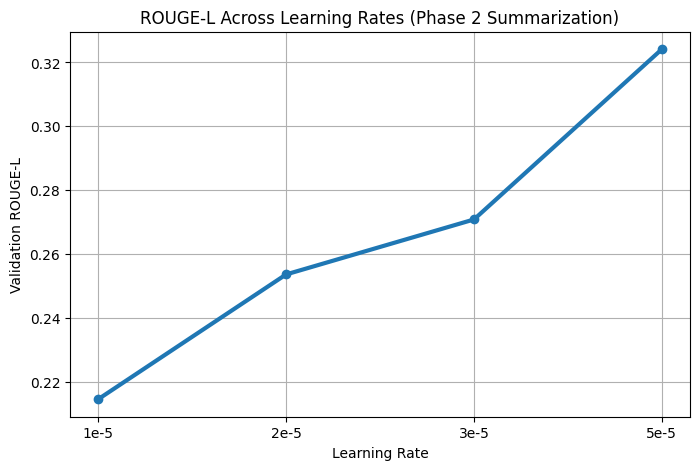

In [ ]:
import matplotlib.pyplot as plt

# results from fine-tuning runs (LR → ROUGE-L)
lr_results = {
    "1e-5": 0.214474,
    "2e-5": 0.253581,
    "3e-5": 0.270805,
    "5e-5": 0.324160
}

learning_rates = list(lr_results.keys())
rouge_l_scores = list(lr_results.values())

# plot LR vs ROUGE-L
plt.figure(figsize=(8,5))
plt.plot(learning_rates, rouge_l_scores, marker='o', linewidth=3)
plt.title("ROUGE-L Across Learning Rates (Phase 2 Summarization)")
plt.xlabel("Learning Rate")
plt.ylabel("Validation ROUGE-L")
plt.grid(True)
plt.show()


#### **Baseline vs. Phase-2 Fine-Tuned Model (ROUGE-L Comparison)**

This block compares the original Phase-1 model’s performance on M3 (no M3 training) against the Phase-2 fine-tuned model.
The bar chart highlights the improvement in ROUGE-L after training on M3.

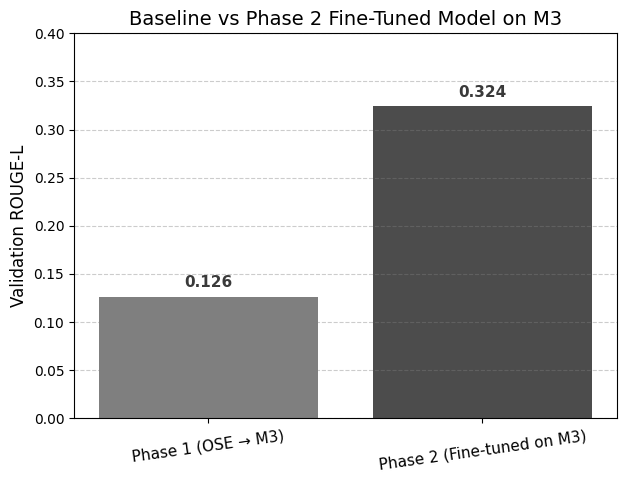

In [ ]:
# Baseline [Phase-1 Model Evaluated on M3 (No Fine-Tuning)] vs Phase-2 Fine-Tuned ROUGE-L Plot
import matplotlib.pyplot as plt

phase1_rougeL = 0.126
phase2_rougeL = 0.324

models = ["Phase 1 (OSE → M3)", "Phase 2 (Fine-tuned on M3)"]
rouge_l = [phase1_rougeL, phase2_rougeL]

plt.figure(figsize=(7,5))

# UPDATED: medium gray + dark gray (NOT black)
bars = plt.bar(models, rouge_l, color=["#7f7f7f", "#4c4c4c"])

# Labels on bars (also dark gray)
for bar, score in zip(bars, rouge_l):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        score + 0.01,
        f"{score:.3f}",
        ha="center",
        fontsize=11,
        fontweight="bold",
        color="#3a3a3a"   # dark gray text
    )

plt.ylabel("Validation ROUGE-L", fontsize=12)
plt.title("Baseline vs Phase 2 Fine-Tuned Model on M3", fontsize=14)
plt.ylim(0, 0.40)
plt.xticks(rotation=8, fontsize=11)
plt.grid(axis="y", linestyle="--", color="gray", alpha=0.4)

plt.show()


In [ ]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

print("\nReady for evaluation / generation (model already trained).")



Ready for evaluation / generation (model already trained).


.

.

.

## **Extra Blocks Added:**
The code blocks added at the end of the notebook reload the saved fine-tuned Phase-2 model in a clean environment to run inference safely. I kept the earlier fine-tuning code unchanged so the full training pipeline remains documented, but because long GPU sessions in Colab often cause CUDA assertion errors, inference cannot reliably run in the same session after training. By reloading the model separately (instead of retraining), I can generate DOC/SENT/CLAIM outputs without repeating fine-tuning, while still preserving the complete training code for transparency and reproducibility.

#### Mount Drive and load the cleaned M3 pairs

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import json
from datasets import Dataset

m3_path = "/content/drive/MyDrive/capstone/m3_all_pairs.jsonl"

rows = []
with open(m3_path, "r", encoding="utf-8") as f:
    for line in f:
        rows.append(json.loads(line))

full_ds = Dataset.from_list(rows)
print("Columns:", full_ds.column_names)

# encode granularity and do the same train/val split as before
full_ds = full_ds.class_encode_column("granularity")
label_names = full_ds.features["granularity"].names
print("Label names:", label_names)

train_test = full_ds.train_test_split(
    test_size=0.15,
    seed=42,
    stratify_by_column="granularity"
)
train_ds = train_test["train"]
val_ds   = train_test["test"]

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Columns: ['input_text', 'target_text', 'granularity']


Casting to class labels:   0%|          | 0/1147 [00:00<?, ? examples/s]

Label names: ['CLAIM', 'DOC', 'SENT']
Train samples: 974
Val samples: 173


#### Load tokenizer + best Phase-2 model from Drive

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

best_dir = "/content/drive/MyDrive/capstone/m3_phase2_best"

tokenizer = AutoTokenizer.from_pretrained(best_dir, use_fast=True)
model     = AutoModelForSeq2SeqLM.from_pretrained(best_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Loaded model from:", best_dir)
print("Using device:", device)


Loaded model from: /content/drive/MyDrive/capstone/m3_phase2_best
Using device: cuda


#### Safe generation helper (no CUDA crash, has max length)

In [ ]:
def generate_no_copy(model, tokenizer, inp, device, max_new_tokens=128):
    # tokenize on CPU or GPU, but with an explicit max_length
    enc = tokenizer(
        inp,
        return_tensors="pt",
        truncation=True,
        max_length=1024,
    )
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        out_ids = model.generate(
            **enc,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            no_repeat_ngram_size=3,
        )

    return tokenizer.decode(out_ids[0], skip_special_tokens=True)


#### Recreate the DOC / SENT / CLAIM examples
Find one index per granularity

In [ ]:
doc_idx = sent_idx = claim_idx = None

for i, ex in enumerate(val_ds):
    g_id = ex["granularity"]        # integer label
    g    = label_names[g_id]        # "DOC", "SENT", "CLAIM"

    if g == "DOC" and doc_idx is None:
        doc_idx = i
    elif g == "SENT" and sent_idx is None:
        sent_idx = i
    elif g == "CLAIM" and claim_idx is None:
        claim_idx = i

    if doc_idx is not None and sent_idx is not None and claim_idx is not None:
        break

print("DOC idx:", doc_idx)
print("SENT idx:", sent_idx)
print("CLAIM idx:", claim_idx)


DOC idx: 0
SENT idx: 2
CLAIM idx: 1


In [ ]:
# Show examples using the reloaded model
def show_example(idx):
    ex   = val_ds[idx]
    g_id = ex["granularity"]
    gran = label_names[g_id]              # "DOC", "SENT", "CLAIM"

    src = ex["input_text"]
    tgt = ex["target_text"]

    ctl = f"<LEVEL:{gran}> "
    inp = ctl + src

    gen = generate_no_copy(model, tokenizer, inp, device)

    print(f"=== {gran} example (idx={idx}) ===")
    print("SOURCE:   ", src[:400], "...\n")
    print("TARGET:   ", tgt[:400], "...\n")
    print("GENERATED:", gen[:400], "...\n")

show_example(doc_idx)
show_example(sent_idx)
show_example(claim_idx)


=== DOC example (idx=0) ===
SOURCE:    Neovascular age-related macular degeneration (nAMD) and polypoidal choroidal vasculopathy (PCV) are both major serosanguinous maculopathies among the Asian elderly. They are similar in phenotype. Genetic variants in high-density lipoprotein (HDL) pathway were discovered to be associated with AMD in two genome-wide association studies. In this study with a Chinese Han cohort, we investigated the im ...

TARGET:    This meta-analysis demonstrates that the T allele in the LIPC rs493258 polymorphism was significantly associated with the risk of any and late AMD. The associations of the locus with early and late AMD risk in various populations need further exploration. ...

GENERATED: CONCLUSIONS: Our meta-analysis revealed that LIPC rs104C polymorphism was significantly associated with the risk of AMD, especially among Caucasians. ...

=== SENT example (idx=2) ===
SOURCE:    In this preliminary study, a significantly greater IOP reduction was achieved

In [1]:
import nbformat

# 1) Path to the notebook you want to clean
path = "/content/Capstone_phase2_Model_FineTunning.ipynb"

# 2) Read the notebook
nb = nbformat.read(path, as_version=4)

removed_any = False

# 3) Remove notebook-level widgets metadata
if "widgets" in nb.metadata:
    print("Removing notebook-level metadata.widgets")
    nb.metadata.pop("widgets")
    removed_any = True

# 4) Remove widgets from each cell's metadata and outputs
for ci, cell in enumerate(nb.cells):
    # cell.metadata.widgets
    md = cell.get("metadata", {})
    if "widgets" in md:
        print(f"Removing cell {ci} metadata.widgets")
        md.pop("widgets")
        removed_any = True

    # output.metadata.widgets for each output in the cell
    for oi, out in enumerate(cell.get("outputs", [])):
        omd = out.get("metadata", {})
        if "widgets" in omd:
            print(f"Removing cell {ci}, output {oi} metadata.widgets")
            omd.pop("widgets")
            removed_any = True

if not removed_any:
    print("No metadata.widgets found at notebook, cell, or output level.")

# 5) Save the cleaned notebook back to the same file
nbformat.write(nb, path)
print("Cleaned notebook saved to:", path)


Removing notebook-level metadata.widgets
Cleaned notebook saved to: /content/Capstone_phase2_Model_FineTunning.ipynb
